# Proyecto Big Data

In [36]:
!pip install -r requirements.txt
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu


In [60]:
import json
from pymongo import MongoClient
import os
import requests
import gzip
import shutil
import time
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import re
from html import unescape
import codecs
import dask.dataframe as dd
import pandas as pd
from tqdm import tqdm
from dask.diagnostics import ProgressBar

#### 1. Bajamos la data correspondiente

In [2]:
def download_data(link, carpeta_destino):
    if not os.path.exists(carpeta_destino):
        os.makedirs(carpeta_destino)
    
    nombre_archivo = os.path.basename(link)
    ruta_comprimido = os.path.join(carpeta_destino, nombre_archivo)
    ruta_descomprimido = os.path.splitext(ruta_comprimido)[0] # Eliminar la extensión .gz

    response = requests.get(link, stream=True)
    if response.status_code == 200:
        with open(ruta_comprimido, 'wb') as f:
            f.write(response.content)
            print(f'Archivo descargado: {ruta_comprimido}')
    else:
        print(f'Error al descargar el archivo: {ruta_comprimido}')
        return None

    with gzip.open(ruta_comprimido, 'rb') as archivo_comprimido:
        with open(ruta_descomprimido, 'wb') as archivo_descomprimido:
            shutil.copyfileobj(archivo_comprimido, archivo_descomprimido)
    print(f'Archivo descomprimido: {ruta_descomprimido}')

    return ruta_descomprimido

link_gift_cards = "https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_2023/raw/review_categories/Gift_Cards.jsonl.gz"
link_meta_gift_cards = "https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_2023/raw/meta_categories/meta_Gift_Cards.jsonl.gz"
carpeta_destino = "data/raw"
ruta_final_gift_cards = download_data(link_gift_cards, carpeta_destino)
ruta_final_meta_gift_cards = download_data(link_meta_gift_cards, carpeta_destino)

Archivo descargado: data/raw\Gift_Cards.jsonl.gz
Archivo descomprimido: data/raw\Gift_Cards.jsonl
Archivo descargado: data/raw\meta_Gift_Cards.jsonl.gz
Archivo descomprimido: data/raw\meta_Gift_Cards.jsonl


#### 2. Incorporamos la data en Mongo DB

Importante: Crear una conexion en MongoDB con los siguientes nombres de coleccion (gift-cards & meta-gift-cards)

In [38]:
# Conectar a MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["Amazon"]
collection = db["gift-cards"]
collection_meta = db["meta-gift-cards"]

2.1 Gift Cards

In [4]:
# Borramos toda la data antes de volver a insertarla
collection.delete_many({})
print("Todos los documentos de la colección han sido eliminados.")

# Leer el archivo JSON Lines
with open("data/raw/Gift_Cards.jsonl", "r", encoding="utf-8") as file:
    for line in file:
        try:
            data = json.loads(line)
            # Insertamos la data
            collection.insert_one(data)
        except json.JSONDecodeError as e:
            print(f"Error al decodificar la línea: {e}")

ServerSelectionTimeoutError: localhost:27017: [WinError 10061] No connection could be made because the target machine actively refused it (configured timeouts: socketTimeoutMS: 20000.0ms, connectTimeoutMS: 20000.0ms), Timeout: 30s, Topology Description: <TopologyDescription id: 674aa5f45232a9d255180b95, topology_type: Unknown, servers: [<ServerDescription ('localhost', 27017) server_type: Unknown, rtt: None, error=AutoReconnect('localhost:27017: [WinError 10061] No connection could be made because the target machine actively refused it (configured timeouts: socketTimeoutMS: 20000.0ms, connectTimeoutMS: 20000.0ms)')>]>

2.2 Meta Gift Cards

In [7]:
# Borramos toda la data antes de volver a insertarla
collection_meta.delete_many({})
print("Todos los documentos de la colección han sido eliminados.")

# Leer el archivo JSON Lines
with open("data/raw/meta_Gift_Cards.jsonl", "r", encoding="utf-8") as file:
    for line in file:
        try:
            data = json.loads(line)
            # Insertamos la data
            collection_meta.insert_one(data)
        except json.JSONDecodeError as e:
            print(f"Error al decodificar la línea: {e}")

Todos los documentos de la colección han sido eliminados.


#### 3. Querys MongoDB

3.1 Consulta para actualizar el campo "main_category" a "Gift Card" de la coleccion de Meta Gift Card

In [8]:
result = collection_meta.update_many({}, {"$set": {"main_category": "Gift Cards"}})
print("Documentos actualizados")

Documentos actualizados


3.2 Consulta en donde se busquen los comentarios que tienen un verified_purchase con valor True, ademas que tengan un rating mayor o igual a 1 y menor o igual a 5, y un helpful_vote mayor o igual a 0

In [39]:
query = {
    "verified_purchase": True,
    "rating": {"$gte": 1, "$lte": 5},
    "helpful_vote": {"$gte": 0},
}

results = collection.find(query)
df = pd.DataFrame(list(results))

#### 4. Dask y Pandas

4.1 Limpieza de data

In [40]:
def clean_text(text):
    if not isinstance(text, str):
        return text
    text = unescape(text) # html entities?

    # text = codecs.decode(text, 'unicode_escape') #decode emojis
    text = re.sub(r'\\u[0-9a-fA-F]{4}', '', text) #remove emojis

    text = re.sub(r'!{2,}', '!', text) #Multiple exclamation

    text = re.sub(r'\.{2,}', ' ', text) # Dots

    text = re.sub(r'<br\s*/?>', ' ', text)  # Para br

    text = re.sub(r'\b([A-Z])(?:\s+([A-Z]))+\b', lambda m: m.group(0).replace(" ", "").lower(), text) # t h i s to this

    text = re.sub(r'[+-]', '', text) #omit some chars

    text = re.sub(r'\u2019', "'", text) # this ´ to this '

    text = re.sub(r'(^|\.\s+)([a-z])', lambda m: m.group(1) + m.group(2).upper(), text) #Capital 
    
    text = re.sub(r'\b[A-Z]{2,}\b', lambda m: m.group().lower(), text) #Words normalized
    
    return text

4.2 Medicion de tiempos

In [41]:
def process_and_filter_pandas(df, max_length=512):
    start_time = time.time()

    df["title"] = df["title"].apply(clean_text)
    df["text"] = df["text"].apply(clean_text)

    filtered_df = df[df["text"].str.len() <= max_length].copy()
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Tiempo transcurrido: {elapsed_time:.2f} segundos")
    
    return filtered_df

def process_and_filter_dask(df, max_length=512):
    start_time = time.time()

    dask_df = dd.from_pandas(df, npartitions=4)
    
    dask_df["title"] = dask_df["title"].apply(clean_text, meta=('title', 'str'))
    dask_df["text"] = dask_df["text"].apply(clean_text, meta=('text', 'str'))
    
    filtered_dask_df = dask_df[dask_df["text"].str.len() <= max_length]
    
    filtered_df = filtered_dask_df.compute()
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Tiempo transcurrido: {elapsed_time:.2f} segundos")
    
    return filtered_df

In [62]:
df_pandas = process_and_filter_pandas(df)
df_dask = process_and_filter_dask(df)

Tiempo transcurrido: 3.45 segundos
Tiempo transcurrido: 7.71 segundos


#### 5. Seteamos LLM

In [43]:
tqdm.pandas()

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

In [44]:
# Funcion para clasificar el texto
def classify_text(row, model):
    input_data = tokenizer(row['text'], return_tensors="pt")
    with torch.no_grad():
        logits = model(**input_data).logits
    predicted_class_id = logits.argmax().item()
    if model.config.id2label[predicted_class_id] == 'POSITIVE':
        return 1
    else:
        return 0

5.1 Generamos el Dataset completo

In [45]:
start_time = time.time()

df_pandas['label'] = df_pandas.progress_apply(
    lambda row: classify_text(row, model), axis=1
)

end_time = time.time()
elapsed_time = end_time - start_time

df_pandas_classify = df_pandas.copy()

print(df_pandas_classify)
print(f"Tiempo transcurrido: {elapsed_time:.2f} segundos")


100%|██████████| 140481/140481 [1:01:49<00:00, 37.87it/s]


                             _id  rating  \
0       6748bafe19c0f99fe2ba20cc     5.0   
1       6748bafe19c0f99fe2ba20ce     5.0   
3       6748bafe19c0f99fe2ba20d1     5.0   
4       6748bafe19c0f99fe2ba20d2     5.0   
5       6748bafe19c0f99fe2ba20d3     5.0   
...                          ...     ...   
141956  6748bb1f19c0f99fe2bc7421     5.0   
141957  6748bb1f19c0f99fe2bc7422     5.0   
141958  6748bb1f19c0f99fe2bc7423     1.0   
141959  6748bb1f19c0f99fe2bc7424     5.0   
141960  6748bb1f19c0f99fe2bc7425     4.0   

                                                    title  \
0                                              Great gift   
1                                            Perfect gift   
3                                                   Cute!   
4                                               Easy gift   
5                                              Great gift   
...                                                   ...   
141956  I gave it to my sister and she immed

In [65]:
df_dask = dd.from_pandas(df_pandas, npartitions=4)

start_time = time.time()

with ProgressBar():
    df_dask['label'] = df_dask.map_partitions(
        lambda partition: partition.apply(
            lambda row: classify_text(row, model), axis=1
        ),
        meta=('label', 'int64')
    )

    df_dask_classify = df_dask.compute()

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Tiempo transcurrido: {elapsed_time:.2f} segundos")
print(df_dask_classify)

[########################################] | 100% Completed | 62m 48s
Tiempo transcurrido: 3772.64 segundos
                             _id  rating  \
0       6748bafe19c0f99fe2ba20cc     5.0   
1       6748bafe19c0f99fe2ba20ce     5.0   
3       6748bafe19c0f99fe2ba20d1     5.0   
4       6748bafe19c0f99fe2ba20d2     5.0   
5       6748bafe19c0f99fe2ba20d3     5.0   
...                          ...     ...   
141956  6748bb1f19c0f99fe2bc7421     5.0   
141957  6748bb1f19c0f99fe2bc7422     5.0   
141958  6748bb1f19c0f99fe2bc7423     1.0   
141959  6748bb1f19c0f99fe2bc7424     5.0   
141960  6748bb1f19c0f99fe2bc7425     4.0   

                                                    title  \
0                                              Great gift   
1                                            Perfect gift   
3                                                   Cute!   
4                                               Easy gift   
5                                              Great gift 

Guardamos en JSON el Dataframe de pandas

In [ ]:
# Convertir todos los valores a texto
df_pandas_classify = df_pandas_classify.astype(str)

In [58]:
df_pandas_classify.to_json(
    "data/processed/gift_cards_classify_pandas.json",
    orient="records",
    lines=True,
    force_ascii=False
)

Guardamos en JSON el Dataframe de Dask

In [66]:
df_dask_classify.to_json(
    "data/processed/gift_cards_classify_dask.json",
    orient="records",
    lines=True,
    force_ascii=False
)

In [ ]:
pip install wandb  matplotlib 


  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached contourpy-1.3.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached pillow-11.0.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (9.1 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 12.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.5/239.5 MB 38.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.7 MB/s eta 0:00:00
Using cached click-8.1.7-py3-none-any.whl (97 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━

#### 6. Seteamos algoritmo de ML

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import numpy as np
import json

file_path = "data/processed/gift_cards_classify_dask.json"
df = pd.read_json(file_path, lines=True)

df.head()


,_id,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,label
0,6748bafe19c0f99fe2ba20cc,5,Great gift,Having Amazon money is always good.,[],B00IX1I3G6,B00IX1I3G6,AHZ6XMOLEWA67S3TX7IWEXXGWSOA,2019-02-11 06:22:38.332,0,True,1
1,6748bafe19c0f99fe2ba20ce,5,Perfect gift,When you have a person who is hard to shop for...,[],B01K8RIM5Y,B005S28ZES,AFZUK3MTBIBEDQOPAK3OATUOUKLA,2018-09-03 01:58:49.239,27,True,1
2,6748bafe19c0f99fe2ba20d1,5,Cute!,That snowman tin is adorable,[],B072L7GTF5,B00ADR2LV6,AECABX3OO3GK7FCPZLFM3LT2E6UA,2020-12-22 18:17:43.303,0,True,1
3,6748bafe19c0f99fe2ba20d2,5,Easy gift,Great and easy gift,[],B00IX1I3G6,B00IX1I3G6,AFSCQMP2EPYLGJN7OBTMEXCBE2OQ,2020-10-07 20:54:57.716,0,True,1
4,6748bafe19c0f99fe2ba20d3,5,Great gift,Super cute nice quality tin Your choose amount,[],B072P5VV4D,B00ADR2LV6,AF4XAUOI5XPGWHCPOTORKBIJSRDA,2019-02-27 06:08:02.370,0,True,1


Distribución de clases:
label
1    110405
0     30076
Name: count, dtype: int64

Porcentaje de clases:
label
1    78.590699
0    21.409301
Name: count, dtype: float64


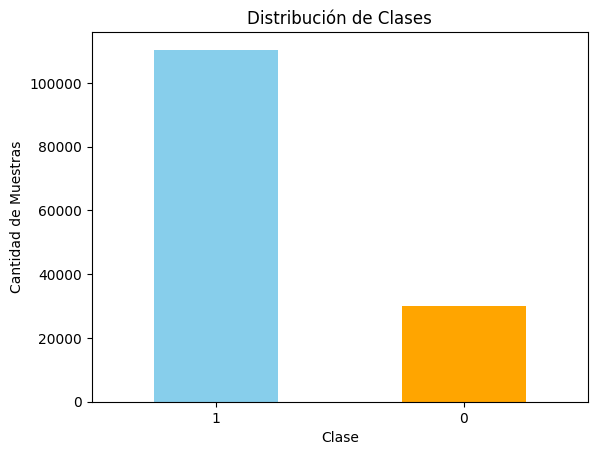

In [ ]:
# Ver si las clases estan desbalancedas 

class_distribution = df['label'].value_counts()

print("Distribución de clases:")
print(class_distribution)

class_percentage = class_distribution / len(df) * 100
print("\nPorcentaje de clases:")
print(class_percentage)

import matplotlib.pyplot as plt

class_distribution.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Distribución de Clases')
plt.xlabel('Clase')
plt.ylabel('Cantidad de Muestras')
plt.xticks(rotation=0)
plt.show()


In [38]:
pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [8]:
import wandb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import joblib
import time
import pandas as pd

param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10]
}

file_path = "data/processed/gift_cards_classify_dask.json"
df = pd.read_json(file_path, lines=True)

# Combinamos  texto y otras variables 
df['combined_text'] = df['title'] + " " + df['text']
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_text = vectorizer.fit_transform(df['combined_text'])

X_tabular = df[['rating', 'helpful_vote', 'verified_purchase']]
scaler = StandardScaler()
X_tabular[['rating', 'helpful_vote']] = scaler.fit_transform(X_tabular[['rating', 'helpful_vote']])

X_combined = pd.concat([pd.DataFrame(X_text.toarray()), X_tabular.reset_index(drop=True)], axis=1)
X_combined.columns = X_combined.columns.astype(str)
y = df['label']

# Usamos smote para balancear las clases 
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_combined, y)

# Dividimos la data en 70 y 30
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)


/var/folders/90/fv3c1zn167730wyd8rs_h_vc0000gn/T/ipykernel_80311/3033091453.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tabular[['rating', 'helpful_vote']] = scaler.fit_transform(X_tabular[['rating', 'helpful_vote']])


In [ ]:
import wandb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import joblib
import time
import pandas as pd

param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10]
}

file_path = "data/processed/gift_cards_classify_dask.json"
df = pd.read_json(file_path, lines=True)

# Combinamos  texto y otras variables 
df['combined_text'] = df['title'] + " " + df['text']
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_text = vectorizer.fit_transform(df['combined_text'])

X_tabular = df[['rating', 'helpful_vote', 'verified_purchase']]
scaler = StandardScaler()
X_tabular[['rating', 'helpful_vote']] = scaler.fit_transform(X_tabular[['rating', 'helpful_vote']])

X_combined = pd.concat([pd.DataFrame(X_text.toarray()), X_tabular.reset_index(drop=True)], axis=1)
X_combined.columns = X_combined.columns.astype(str)
y = df['label']

# Usamos smote para balancear las clases 
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_combined, y)

# Dividimos la data en 70 y 30
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

for n_estimators in param_grid['n_estimators']:
    for max_depth in param_grid['max_depth']:
        for min_samples_split in param_grid['min_samples_split']:
            
            wandb.init(project="random-forest", config={
                "n_estimators": n_estimators,
                "max_depth": max_depth,
                "min_samples_split": min_samples_split,
            })
            
            config = wandb.config
            
            model = RandomForestClassifier(
                n_estimators=config.n_estimators,
                max_depth=config.max_depth,
                min_samples_split=config.min_samples_split,
                random_state=42
            )
            
            start_time = time.time()
            model.fit(X_train, y_train)
            execution_time = time.time() - start_time
            
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            report = classification_report(y_test, y_pred, output_dict=True)
            
            wandb.log({
                "test_accuracy": accuracy,
                "precision_class_0": report['0']['precision'],
                "recall_class_0": report['0']['recall'],
                "f1_score_class_0": report['0']['f1-score'],
                "precision_class_1": report['1']['precision'],
                "recall_class_1": report['1']['recall'],
                "f1_score_class_1": report['1']['f1-score'],
                "execution_time": execution_time
            })
            
            model_path = f"random_forest_model_{n_estimators}_{max_depth}_{min_samples_split}.pkl"
            joblib.dump(model, model_path)
            artifact = wandb.Artifact(f"random_forest_model", type="model")
            artifact.add_file(model_path)
            wandb.log_artifact(artifact)
            
            wandb.finish()


/var/folders/90/fv3c1zn167730wyd8rs_h_vc0000gn/T/ipykernel_94483/2194717617.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tabular[['rating', 'helpful_vote']] = scaler.fit_transform(X_tabular[['rating', 'helpful_vote']])
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: bladimir-alferez (bladimir-alferez-utec-u-de-ingenier-a-tecnolog-a). Use `wandb login --relogin` to force relogin


execution_time,▁
f1_score_class_0,▁
f1_score_class_1,▁
precision_class_0,▁
precision_class_1,▁
recall_class_0,▁
recall_class_1,▁
test_accuracy,▁
execution_time,15.14156
f1_score_class_0,0.7947
f1_score_class_1,0.82427


execution_time,▁
f1_score_class_0,▁
f1_score_class_1,▁
precision_class_0,▁
precision_class_1,▁
recall_class_0,▁
recall_class_1,▁
test_accuracy,▁
execution_time,13.6543
f1_score_class_0,0.78975
f1_score_class_1,0.82325


execution_time,▁
f1_score_class_0,▁
f1_score_class_1,▁
precision_class_0,▁
precision_class_1,▁
recall_class_0,▁
recall_class_1,▁
test_accuracy,▁
execution_time,14.04379
f1_score_class_0,0.79115
f1_score_class_1,0.82281


execution_time,▁
f1_score_class_0,▁
f1_score_class_1,▁
precision_class_0,▁
precision_class_1,▁
recall_class_0,▁
recall_class_1,▁
test_accuracy,▁
execution_time,27.91016
f1_score_class_0,0.81912
f1_score_class_1,0.84179


execution_time,▁
f1_score_class_0,▁
f1_score_class_1,▁
precision_class_0,▁
precision_class_1,▁
recall_class_0,▁
recall_class_1,▁
test_accuracy,▁
execution_time,27.6452
f1_score_class_0,0.82267
f1_score_class_1,0.8444


execution_time,▁
f1_score_class_0,▁
f1_score_class_1,▁
precision_class_0,▁
precision_class_1,▁
recall_class_0,▁
recall_class_1,▁
test_accuracy,▁
execution_time,25.99027
f1_score_class_0,0.81741
f1_score_class_1,0.84063


execution_time,▁
f1_score_class_0,▁
f1_score_class_1,▁
precision_class_0,▁
precision_class_1,▁
recall_class_0,▁
recall_class_1,▁
test_accuracy,▁
execution_time,152.82687
f1_score_class_0,0.92257
f1_score_class_1,0.91943


execution_time,▁
f1_score_class_0,▁
f1_score_class_1,▁
precision_class_0,▁
precision_class_1,▁
recall_class_0,▁
recall_class_1,▁
test_accuracy,▁
execution_time,140.69754
f1_score_class_0,0.92129
f1_score_class_1,0.91883


execution_time,▁
f1_score_class_0,▁
f1_score_class_1,▁
precision_class_0,▁
precision_class_1,▁
recall_class_0,▁
recall_class_1,▁
test_accuracy,▁
execution_time,131.34756
f1_score_class_0,0.91869
f1_score_class_1,0.91631


execution_time,▁
f1_score_class_0,▁
f1_score_class_1,▁
precision_class_0,▁
precision_class_1,▁
recall_class_0,▁
recall_class_1,▁
test_accuracy,▁
execution_time,20.90488
f1_score_class_0,0.79509
f1_score_class_1,0.82552


execution_time,▁
f1_score_class_0,▁
f1_score_class_1,▁
precision_class_0,▁
precision_class_1,▁
recall_class_0,▁
recall_class_1,▁
test_accuracy,▁
execution_time,21.38406
f1_score_class_0,0.79253
f1_score_class_1,0.82435


execution_time,▁
f1_score_class_0,▁
f1_score_class_1,▁
precision_class_0,▁
precision_class_1,▁
recall_class_0,▁
recall_class_1,▁
test_accuracy,▁
execution_time,21.15794
f1_score_class_0,0.7921
f1_score_class_1,0.82406


execution_time,▁
f1_score_class_0,▁
f1_score_class_1,▁
precision_class_0,▁
precision_class_1,▁
recall_class_0,▁
recall_class_1,▁
test_accuracy,▁
execution_time,41.6245
f1_score_class_0,0.8257
f1_score_class_1,0.84517


execution_time,▁
f1_score_class_0,▁
f1_score_class_1,▁
precision_class_0,▁
precision_class_1,▁
recall_class_0,▁
recall_class_1,▁
test_accuracy,▁
execution_time,41.61512
f1_score_class_0,0.82633
f1_score_class_1,0.84494


execution_time,▁
f1_score_class_0,▁
f1_score_class_1,▁
precision_class_0,▁
precision_class_1,▁
recall_class_0,▁
recall_class_1,▁
test_accuracy,▁
execution_time,49.75761
f1_score_class_0,0.82621
f1_score_class_1,0.84509


execution_time,▁
f1_score_class_0,▁
f1_score_class_1,▁
precision_class_0,▁
precision_class_1,▁
recall_class_0,▁
recall_class_1,▁
test_accuracy,▁
execution_time,295.07082
f1_score_class_0,0.92414
f1_score_class_1,0.92144


execution_time,▁
f1_score_class_0,▁
f1_score_class_1,▁
precision_class_0,▁
precision_class_1,▁
recall_class_0,▁
recall_class_1,▁
test_accuracy,▁
execution_time,288.05953
f1_score_class_0,0.92215
f1_score_class_1,0.91976


execution_time,▁
f1_score_class_0,▁
f1_score_class_1,▁
precision_class_0,▁
precision_class_1,▁
recall_class_0,▁
recall_class_1,▁
test_accuracy,▁
execution_time,269.49814
f1_score_class_0,0.9198
f1_score_class_1,0.91743


execution_time,▁
f1_score_class_0,▁
f1_score_class_1,▁
precision_class_0,▁
precision_class_1,▁
recall_class_0,▁
recall_class_1,▁
test_accuracy,▁
execution_time,46.85332
f1_score_class_0,0.79543
f1_score_class_1,0.82767


execution_time,▁
f1_score_class_0,▁
f1_score_class_1,▁
precision_class_0,▁
precision_class_1,▁
recall_class_0,▁
recall_class_1,▁
test_accuracy,▁
execution_time,40.3501
f1_score_class_0,0.79404
f1_score_class_1,0.82626


execution_time,▁
f1_score_class_0,▁
f1_score_class_1,▁
precision_class_0,▁
precision_class_1,▁
recall_class_0,▁
recall_class_1,▁
test_accuracy,▁
execution_time,40.31953
f1_score_class_0,0.79406
f1_score_class_1,0.82591


execution_time,▁
f1_score_class_0,▁
f1_score_class_1,▁
precision_class_0,▁
precision_class_1,▁
recall_class_0,▁
recall_class_1,▁
test_accuracy,▁
execution_time,89.17077
f1_score_class_0,0.82864
f1_score_class_1,0.84775


execution_time,▁
f1_score_class_0,▁
f1_score_class_1,▁
precision_class_0,▁
precision_class_1,▁
recall_class_0,▁
recall_class_1,▁
test_accuracy,▁
execution_time,90.73299
f1_score_class_0,0.82681
f1_score_class_1,0.8468


execution_time,▁
f1_score_class_0,▁
f1_score_class_1,▁
precision_class_0,▁
precision_class_1,▁
recall_class_0,▁
recall_class_1,▁
test_accuracy,▁
execution_time,101.11426
f1_score_class_0,0.82619
f1_score_class_1,0.8464


execution_time,▁
f1_score_class_0,▁
f1_score_class_1,▁
precision_class_0,▁
precision_class_1,▁
recall_class_0,▁
recall_class_1,▁
test_accuracy,▁
execution_time,661.50594
f1_score_class_0,0.92502
f1_score_class_1,0.92257


execution_time,▁
f1_score_class_0,▁
f1_score_class_1,▁
precision_class_0,▁
precision_class_1,▁
recall_class_0,▁
recall_class_1,▁
test_accuracy,▁
execution_time,655.68998
f1_score_class_0,0.92323
f1_score_class_1,0.92098


execution_time,▁
f1_score_class_0,▁
f1_score_class_1,▁
precision_class_0,▁
precision_class_1,▁
recall_class_0,▁
recall_class_1,▁
test_accuracy,▁
execution_time,576.00474
f1_score_class_0,0.92039
f1_score_class_1,0.91815


In [4]:
import joblib

# Guardar el vectorizer y el scaler después de entrenarlo, para futuras pruebas
joblib.dump(vectorizer, "vectorizer.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [9]:
import wandb
import joblib
from sklearn.metrics import classification_report
import os

api = wandb.Api()

artifact = api.artifact("bladimir-alferez-utec-u-de-ingenier-a-tecnolog-a/random-forest/random_forest_model:v24")
artifact_dir = artifact.download()

model_path = f"{artifact_dir}/random_forest_model_200_None_2.pkl" 

best_model = joblib.load(model_path)


wandb: Downloading large artifact random_forest_model:v24, 832.71MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:2.8


In [10]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Resultados del modelo en el conjunto de prueba:")
print(f"Accuracy: {accuracy:.4f}")
print("Reporte de clasificación:")
print(report)


Resultados del modelo en el conjunto de prueba:
Accuracy: 0.9238
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.91      0.94      0.93     33038
           1       0.94      0.91      0.92     33205

    accuracy                           0.92     66243
   macro avg       0.92      0.92      0.92     66243
weighted avg       0.92      0.92      0.92     66243



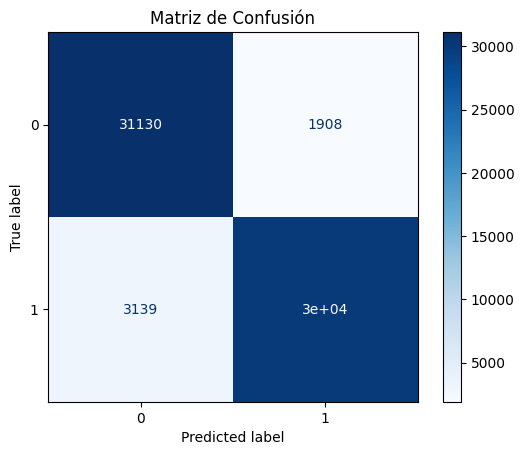

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()


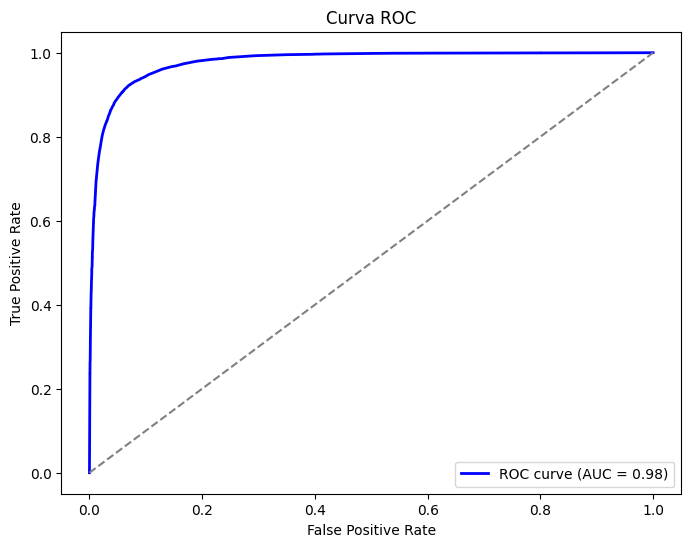

In [ ]:
from sklearn.metrics import roc_curve, auc

y_proba = best_model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()


In [11]:
# Probar el modelo con nueva data

import joblib
import numpy as np

vectorizer = joblib.load("vectorizer.pkl")
scaler = joblib.load("scaler.pkl")  

test_sample = {
    "title": "Terrible experience",
    "text": "This was the worst gift card I've ever used. It didn't work at all!",
    "rating": 5,  
    "helpful_vote": 10,  
    "verified_purchase": True 
}


# Preprocesar el input
combined_text = test_sample["title"] + " " + test_sample["text"]
text_transformed = vectorizer.transform([combined_text]) 

tabular_data = np.array([
    test_sample["rating"],
    test_sample["helpful_vote"]
]).reshape(1, -1)
tabular_data_scaled = scaler.transform(tabular_data)

verified_purchase = np.array([[1 if test_sample["verified_purchase"] else 0]])  
tabular_data_final = np.hstack([tabular_data_scaled, verified_purchase])  

test_input = np.hstack([text_transformed.toarray(), tabular_data_final])

predicted_label = best_model.predict(test_input)
print(f"Etiqueta predicha: {predicted_label[0]}")


Etiqueta predicha: 0


/opt/anaconda3/envs/proyecto_BD/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/proyecto_BD/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


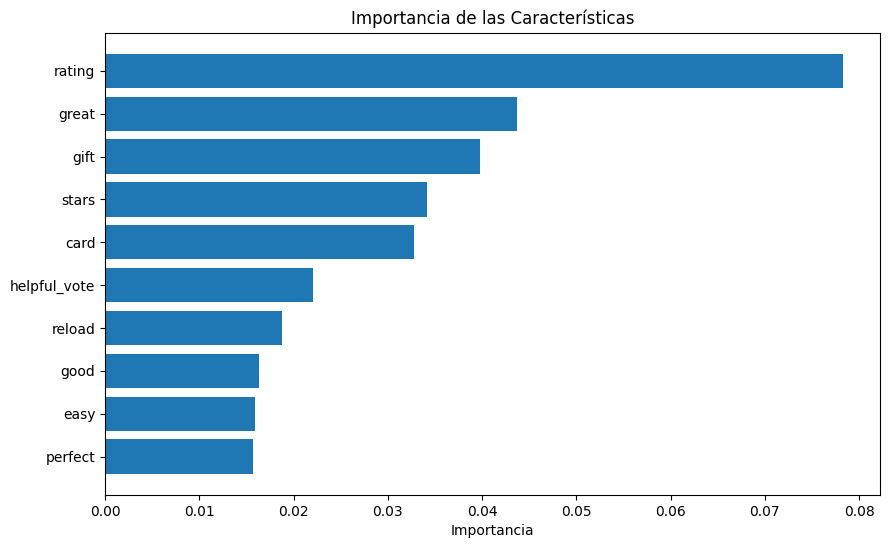

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = best_model.feature_importances_
features = vectorizer.get_feature_names_out().tolist() + ['rating', 'helpful_vote', 'verified_purchase']

# Ordenar características por importancia
sorted_indices = np.argsort(importances)[::-1]
top_n = 10  # Número de características más importantes

# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), np.array(importances)[sorted_indices[:top_n]])
plt.yticks(range(top_n), np.array(features)[sorted_indices[:top_n]])
plt.gca().invert_yaxis()
plt.title("Importancia de las Características")
plt.xlabel("Importancia")
plt.show()


In [12]:
pip install wordcloud


Note: you may need to restart the kernel to use updated packages.


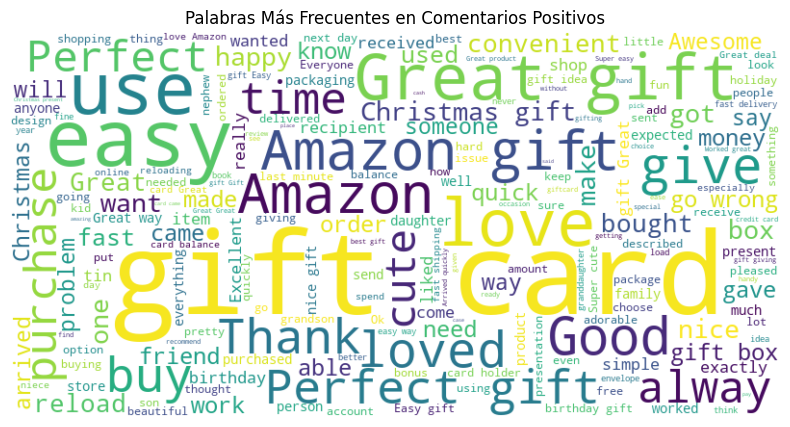

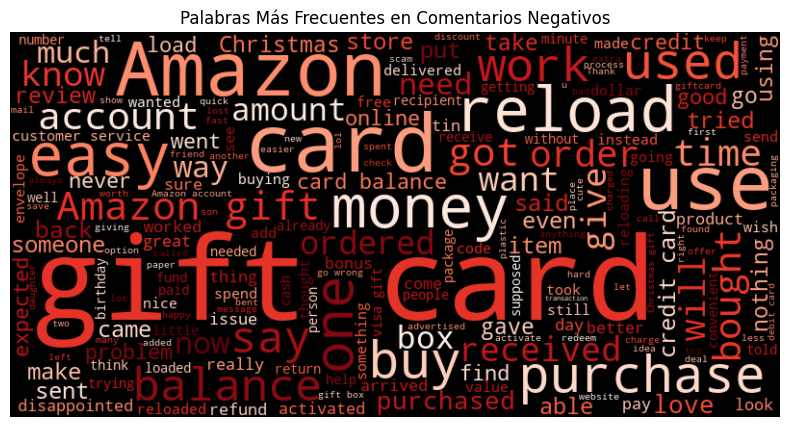

In [16]:
from wordcloud import WordCloud

# Dividir en clases
positive_reviews = df[df['label'] == 1]['text']
negative_reviews = df[df['label'] == 0]['text']

# Crear nubes de palabras
positive_text = " ".join(positive_reviews)
negative_text = " ".join(negative_reviews)

# Nube de palabras para positivos
wc_positive = WordCloud(width=800, height=400, background_color="white").generate(positive_text)
plt.figure(figsize=(10, 5))
plt.imshow(wc_positive, interpolation="bilinear")
plt.axis("off")
plt.title("Palabras Más Frecuentes en Comentarios Positivos")
plt.show()

# Nube de palabras para negativos
wc_negative = WordCloud(width=800, height=400, background_color="black", colormap="Reds").generate(negative_text)
plt.figure(figsize=(10, 5))
plt.imshow(wc_negative, interpolation="bilinear")
plt.axis("off")
plt.title("Palabras Más Frecuentes en Comentarios Negativos")
plt.show()


In [17]:
positive_contributions = np.argsort(importances[-len(features):-len(features)//2])[::-1][:10]
negative_contributions = np.argsort(importances[-len(features)//2:])[::-1][:10]

print("Palabras más relevantes para clasificar positivos:")
print(np.array(features)[positive_contributions])

print("Palabras más relevantes para clasificar negativos:")
print(np.array(features)[negative_contributions])


Palabras más relevantes para clasificar positivos:
['great' 'gift' 'card' 'good' 'easy' 'amazon' 'cute' 'expected' 'cards'
 'balance']
Palabras más relevantes para clasificar negativos:
['laying' 'fast' 'lazy' 'customers' 'butt' 'accepting' 'arizona' 'az'
 'accepts' 'hoops']


#### 7. Implementar el modelo en Spark

In [26]:
pip install pyspark


Note: you may need to restart the kernel to use updated packages.


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, HashingTF, IDF, Tokenizer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col, concat_ws

spark = SparkSession.builder.appName("RandomForestWithText").getOrCreate()

file_path = "data/processed/gift_cards_classify_dask.json"
df = spark.read.json(file_path)

df = df.withColumn("combined_text", concat_ws(" ", col("title"), col("text")))

df = df.withColumn("verified_purchase", col("verified_purchase").cast("integer"))

df = df.select("rating", "helpful_vote", "verified_purchase", "label", "combined_text")

indexer = StringIndexer(inputCol="label", outputCol="indexed_label")
df = indexer.fit(df).transform(df)

tokenizer = Tokenizer(inputCol="combined_text", outputCol="tokens")
df = tokenizer.transform(df)

hashingTF = HashingTF(inputCol="tokens", outputCol="raw_text_features", numFeatures=5000)
df = hashingTF.transform(df)

idf = IDF(inputCol="raw_text_features", outputCol="text_features")
idf_model = idf.fit(df)
df = idf_model.transform(df)

assembler = VectorAssembler(
    inputCols=["rating", "helpful_vote", "verified_purchase", "text_features"], 
    outputCol="features"
)
df = assembler.transform(df)

class_0 = df.filter(col("indexed_label") == 0.0)
class_1 = df.filter(col("indexed_label") == 1.0)

min_count = min(class_0.count(), class_1.count())

balanced_class_0 = class_0.sample(withReplacement=False, fraction=min_count / class_0.count())
balanced_class_1 = class_1.sample(withReplacement=False, fraction=min_count / class_1.count())

balanced_data = balanced_class_0.union(balanced_class_1)

train_data, test_data = balanced_data.randomSplit([0.7, 0.3], seed=42)

rf = RandomForestClassifier(
    labelCol="indexed_label", 
    featuresCol="features"
)

# Configuamos el grid search y cross validation
paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [5, 10])
             .addGrid(rf.numTrees, [50, 100])
             .addGrid(rf.maxBins, [20, 60])
             .build())

evaluator = BinaryClassificationEvaluator(
    labelCol="indexed_label", 
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

cv = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5
)

cvModel = cv.fit(train_data)

predictions = cvModel.transform(test_data)

accuracy = evaluator.evaluate(predictions)
print(f"Accuracy del mejor modelo: {accuracy * 100:.2f}%")

bestModel = cvModel.bestModel
print("Mejores hiperparámetros:")
print(f"  - maxDepth: {bestModel._java_obj.getMaxDepth()}")
print(f"  - numTrees: {bestModel._java_obj.getNumTrees()}")

bestModel.save("best_random_forest_model_with_text")

final_predictions = bestModel.transform(test_data)
final_predictions.select("indexed_label", "prediction", "probability").show()


evaluator_accuracy = BinaryClassificationEvaluator(
    labelCol="indexed_label", 
    rawPredictionCol="rawPrediction", 
    metricName="areaUnderROC"
)
accuracy = evaluator_accuracy.evaluate(final_predictions)
print(f"Área bajo la curva ROC: {accuracy:.4f}")


24/12/02 02:27:38 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
24/12/02 02:27:51 WARN MemoryStore: Not enough space to cache rdd_3679_14 in memory! (computed 12.2 MiB so far)
24/12/02 02:27:51 WARN MemoryStore: Not enough space to cache rdd_3679_15 in memory! (computed 5.3 MiB so far)
24/12/02 02:27:51 WARN MemoryStore: Not enough space to cache rdd_3679_18 in memory! (computed 12.2 MiB so far)
24/12/02 02:27:51 WARN MemoryStore: Not enough space to cache rdd_3679_20 in memory! (computed 5.3 MiB so far)
24/12/02 02:27:51 WARN MemoryStore: Not enough space to cache rdd_3679_17 in memory! (computed 8.1 MiB so far)
24/12/02 02:27:51 WARN MemoryStore: Not enough space to cache rdd_3679_19 in memory! (computed 8.1 MiB so far)
24/12/02 02:27:51 WARN MemoryStore: Not enough space to cache rdd_3679_13 in memory! (computed 8.1 MiB so far)
24/12/02 02:27:51 WARN MemoryStore: Not enough space to cache rdd_3679_16 in memory! (computed 8.1 Mi

Accuracy del mejor modelo: 85.13%
Mejores hiperparámetros:
  - maxDepth: 10
  - numTrees: 100


24/12/02 02:37:10 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


+-------------+----------+--------------------+
|indexed_label|prediction|         probability|
+-------------+----------+--------------------+
|          0.0|       1.0|[0.42651681799652...|
|          0.0|       1.0|[0.39578326085701...|
|          0.0|       0.0|[0.54261190090549...|
|          0.0|       1.0|[0.48986015001263...|
|          0.0|       1.0|[0.24455895908908...|
|          0.0|       1.0|[0.45358834032549...|
|          0.0|       1.0|[0.38978388413711...|
|          0.0|       1.0|[0.48855290019228...|
|          0.0|       1.0|[0.34873105911458...|
|          0.0|       1.0|[0.25413371912385...|
|          0.0|       1.0|[0.47430547919836...|
|          0.0|       0.0|[0.53380099159160...|
|          0.0|       1.0|[0.40592567617748...|
|          0.0|       0.0|[0.52015302411209...|
|          0.0|       1.0|[0.31090468835465...|
|          0.0|       1.0|[0.37916954639699...|
|          0.0|       1.0|[0.36105239958523...|
|          0.0|       0.0|[0.55473291707

24/12/02 02:37:10 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


Área bajo la curva ROC: 0.8513
